In [1]:
# Import data

In [3]:
import pandas as pd
import numpy as np
import cPickle
import pickle

In [4]:
lines =open("database.txt").read().strip().split('\n')

In [5]:
saved_indices = open("save_indices", "rb")
indices = pickle.load(saved_indices)

indices = np.array([i for i in range(len(lines))])
np.random.shuffle(indices)
to_save_indices = open("save_indices", "wb")
pickle.dump(indices, to_save_indices)

to_save_indices.close()

In [6]:
lines = np.array(lines)
lines = lines[indices]

In [7]:
train_lines = lines[: int(len(lines) * 0.8)]
test_lines = lines[int(len(lines) * 0.8):]

# Extract random examples for training

In [8]:
from basic_functions import *

In [9]:
randomExample(train_lines, True)

('jborms', 'goldstar')

In [10]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

In [11]:
char_vect = np.array(['j', 'a', 'k', 'c', 'i', 'e', '\r', 'm', 'l', 'x', 'f', 'z', 'b', 'o', 'r', 'g', 'h', 'p',
 'n' ,'d' ,'1', '2' ,'8' ,'7' ,'3', 't', '4', 'y' ,'5' ,'0','9', 's', '6', 'u', 'P', 'G',
 'w' ,'v' ,'q', 'N', 'W' ,'T' ,'H', 'A', 'B', '.', 'L', 'X' ,'I' ,'#' ,'V' ,'C' ,'R', 'D',
 'F' ,'E' ,'Q' ,'M' ,'-' ,'_' ,'Y' ,'Z', 'K' ,'J' ,'O' ,'S' ,'U' ,'*', '%' ,'?' ,'!', '&',
 '$' ,'@' ,'=' ,';' ,' ', '\\', '`' ,'\x03', '|', '+', "'", '^', '[', '}', '~', '(', '\xaa',
 '\xbb' ,']', '/', '\xac' ,')', ':' ,'{' ,'\xe9' ,'\xbc', '\x0f' ,'>', '<' ,'\xa6',
 '\x02' ,'\x17', '\x07'])

# Build models

In [12]:

class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN2, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        #self.encoder = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, dropout=0.1)
        self.lin = nn.Linear(hidden_size, output_size)
        #self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        #self.o2o = nn.Linear(hidden_size + output_size, output_size)
        #self.softmax = nn.LogSoftmax()

    def forward(self, input, hidden):
        #hidden = self.i2h(input_combined)
        #output = self.i2o(input_combined)
        #output_combined = torch.cat((hidden, output), 1)
        output, hidden = self.lstm(input.view(len(input), 1, -1), hidden)
        output = self.lin(output.view(1, -1))
        #output = self.softmax(output)
        return output, hidden


    def initHidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (Variable(torch.zeros(self.n_layers, 1, self.hidden_size)),
                Variable(torch.zeros(self.n_layers, 1, self.hidden_size)))

In [13]:
class USERNAME_ENCODER(nn.Module):
    def __init__(self, input_size, hidden_size , n_layers=1):
        super(USERNAME_ENCODER, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        #self.encoder = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, dropout=0.1)
        #self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        #self.o2o = nn.Linear(hidden_size + output_size, output_size)
        #self.softmax = nn.LogSoftmax()

    def forward(self, input, hidden):
        #hidden = self.i2h(input_combined)
        #output = self.i2o(input_combined)
        #output_combined = torch.cat((hidden, output), 1)
        output, hidden = self.lstm(input.view(len(input), 1, -1), hidden)
        #output = self.softmax(output)
        return output, hidden


    def initHidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (Variable(torch.zeros(self.n_layers, 1, self.hidden_size)),
                Variable(torch.zeros(self.n_layers, 1, self.hidden_size)))

In [14]:
class RNN_WITH_USERNAME(nn.Module):
    def __init__(self, input_size, hidden_size_encoded_username, hidden_size, output_size, n_layers=1):
        super(RNN_WITH_USERNAME, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        #self.encoder = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size_encoded_username + input_size, hidden_size, n_layers, dropout=0.1)
        self.lin = nn.Linear(hidden_size, output_size)
        #self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        #self.o2o = nn.Linear(hidden_size + output_size, output_size)
        #self.softmax = nn.LogSoftmax()

    def forward(self, username_tensor, input_tensor, hidden):
        #hidden = self.i2h(input_combined)
        #output = self.i2o(input_combined)
        input_combined = torch.cat((username_tensor, input_tensor), 1)
        output, hidden = self.lstm(input_combined.view(len(input_combined), 1, -1), hidden)
        output = self.lin(F.dropout(output.view(1, -1), 0.1, training=self.training))
        #output = self.softmax(output)
        return output, hidden


    def initHidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (Variable(torch.zeros(self.n_layers, 1, self.hidden_size)),
                Variable(torch.zeros(self.n_layers, 1, self.hidden_size)))

# Retrieving the network

In [15]:
import cPickle

In [16]:
def retrieve(rnn_object, file_name_rnn, file_name_parameters, file_name_encoder=None, encoder_object=None):
    saved_params = open(file_name_parameters, "rb")
    saved_rnn = open(file_name_rnn, "rb")
    params = cPickle.load(saved_params)
    if not encoder_object:
        rnn = rnn_object(params["input_size"], params["hidden_size"], params["input_size"])
    else:
        saved_encoder = open(file_name_encoder, 'rb') 
        rnn = rnn_object(params["input_size"], params["encoder_hidden_size"], params["rnn_hidden_size"], params["input_size"], 1)  #TODO : n_layers change
        encoder = encoder_object(params["input_size"], params["encoder_hidden_size"], 1)
        encoder.load_state_dict(torch.load(saved_encoder))
        saved_encoder.close()
    rnn.load_state_dict(torch.load(saved_rnn))
    saved_rnn.close()
    saved_params.close()
    return rnn if not encoder_object else (rnn, encoder)

rnn_with_username, username_encoder = retrieve(RNN_WITH_USERNAME, "rnn_with_username", "saved_parameters_rnn_with_username", "username_encoder", USERNAME_ENCODER)
rnn_vanilla = retrieve(RNN2, "rnn_vanilla", "saved_parameters_vanilla_network")

# Convert the LSTM to an automaton 

 ## Are hidden_states robust to noise ?

In [27]:
l_mean_h = list()
l_mean_c = list()
for state in state_list:
    a, b = state[1][0].data.numpy(), state[1][1].data.numpy()
    l_mean_h.append(np.mean(np.abs(a)))
    l_mean_c.append(np.mean(np.abs(b)))

In [28]:
mean_c = np.mean(l_mean_c)
mean_h = np.mean(l_mean_h)

In [29]:
def hellinger(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q))**2)) / np.sqrt(2)

def KL_divergence(p, q):
    return np.sum(p * np.log(p / q.astype(float)))

def JS_divergence(p, q):
    """ turn KL divergence into a metric (symetric and triangular inequality)"""
    m = (p + q) / float(2)
    return 0.5 * KL_divergence(p, m) + 0.5 * KL_divergence(q, m)

In [33]:
def noisify(vector, scale, noise_type="normal"):
    noise = np.random.normal(scale=scale, size=vector.size())
    if type(vector) == Variable:
        return vector + Variable(torch.FloatTensor(noise))
    if type(vector) == torch.FloatTensor:
        return vector + torch.FloatTensor(noise)

In [36]:
%%time
input_tensor = Variable(text2input(" ")[-1])
hidden = state_list[140][1]
hidden_with_noise = (noisify(hidden[0], 0.2), noisify(hidden[1], 0.2))
output, new_hidden = rnn_vanilla(input_tensor, hidden)
output_after_noise, new_hidden_after_noise = rnn_vanilla(input_tensor, hidden_with_noise)

CPU times: user 16 ms, sys: 4 ms, total: 20 ms
Wall time: 127 ms


In [37]:
output, output_after_noise = F.softmax(output), F.softmax(output_after_noise)

In [38]:
KL_divergence(output.data.numpy(), output_after_noise.data.numpy())

0.1711351441001086

In [39]:
hellinger(output.data.numpy(), output_after_noise.data.numpy())

0.1967698747513254

In [41]:
%%time
noise_list = [0.005 * i for i in range(20)]
percentage_hidden_noise_list = [(noise / mean_h) * 100 for noise in noise_list]
percentage_cell_noise_list = [(noise / mean_c) * 100 for noise in noise_list]
KL_list = list()
hellinger_list = list()
JS_list = list()
for noise in noise_list:
    KL = list()
    helling = list()
    JS = list()
    for state in state_list[:100]:
        for char in np.random.choice(char_vect, 10):
            input_tensor = Variable(text2input(" ")[-1])
            hidden = state_list[100][1]
            hidden_with_noise = (noisify(hidden[0], noise), noisify(hidden[1], noise))
            output, new_hidden = rnn_vanilla(input_tensor, hidden)
            output_after_noise, new_hidden_after_noise = rnn_vanilla(input_tensor, hidden_with_noise)
            output, output_after_noise = F.softmax(output), F.softmax(output_after_noise)
            KL.append(KL_divergence(output.data.numpy(), output_after_noise.data.numpy()))
            helling.append(hellinger(output.data.numpy(), output_after_noise.data.numpy()))
            JS.append(JS_divergence(output.data.numpy(), output_after_noise.data.numpy()))
    KL_list.append(KL)
    hellinger_list.append(helling)
    JS_list.append(JS)

CPU times: user 29min 57s, sys: 6.72 s, total: 30min 4s
Wall time: 2min 49s


In [43]:
mean_KL_list = [np.mean(l) for l in KL_list]
mean_hellinger_list = [np.mean(l) for l in hellinger_list]
mean_JS_list = [np.mean(l) for l in JS_list]
lower_bound_KL_list = [np.mean(l) - np.std(l) for l in KL_list]
higher_bound_KL_list = [np.mean(l) + np.std(l) for l in KL_list]
lower_bound_JS_list = [np.mean(l) - np.std(l) for l in JS_list]
higher_bound_JS_list = [np.mean(l) + np.std(l) for l in JS_list]
lower_bound_hellinger_list = [np.mean(l) - np.std(l) for l in hellinger_list]
higher_bound_hellinger_list = [np.mean(l) + np.std(l) for l in hellinger_list]

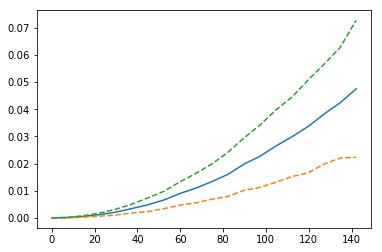

In [44]:
plt.plot(percentage_hidden_noise_list, mean_KL_list)
plt.plot(percentage_hidden_noise_list, lower_bound_KL_list, "--")
plt.plot(percentage_hidden_noise_list, higher_bound_KL_list, "--")
plt.show()

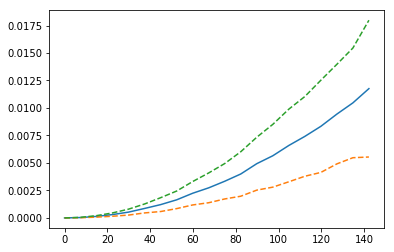

In [45]:
plt.plot(percentage_hidden_noise_list, mean_JS_list)
plt.plot(percentage_hidden_noise_list, lower_bound_JS_list, "--")
plt.plot(percentage_hidden_noise_list, higher_bound_JS_list, "--")
plt.show()

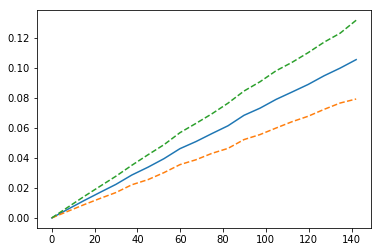

In [46]:
plt.plot(percentage_hidden_noise_list, mean_hellinger_list)
plt.plot(percentage_hidden_noise_list, lower_bound_hellinger_list, "--")
plt.plot(percentage_hidden_noise_list, higher_bound_hellinger_list, "--")
plt.show()

## Collect LSTM memory states when it goes through our database

In [17]:
word_list = list()
for couple in train_lines:
    try:
        word = couple.split("\t")[1][:-1]
        if len(word) > 1:
            word_list.append(couple.split("\t")[1][:-1])
    except:
        continue
#word_list = sorted(word_list)

In [18]:
def equal(var1, var2):
    return (var1.data == var2.data).all()

In [58]:

state_list_fast = [(0, rnn_vanilla.initHidden())]
rnn_vanilla.eval()
reduced_word_list = word_list[5000000: 5000010]
for i, word in enumerate(reduced_word_list):
    word_tensor = Variable(text2input(word))
    hidden = rnn_vanilla.initHidden()
    for j, char_as_vect in enumerate(word_tensor):
        if i >= 1:
            saved_output, saved_hidden = state_list[- (len(reduced_word_list[i -1]) + 2)][:2] # to check if the hidden state is the same (i.e if the prefix is the same)
            #print(hidden[0],  saved_hidden[0])
            if equal(saved_hidden[0], hidden[0]) and equal(saved_hidden[1], hidden[1]):
                saved_output2, saved_hidden2 = state_list[- (len(reduced_word_list[i -1]) + 1)][:2]  # to replace the output and hidden state
                output, hidden = saved_output2, saved_hidden2
            else:
                output, hidden = rnn_vanilla(char_as_vect, hidden)
                output = F.softmax(output)
        else:
            output, hidden = rnn_vanilla(char_as_vect, hidden)
            output = F.softmax(output)
        state_list_fast.append((output, hidden))
l = state_list_fast

incroyable2
incroyable2
incroyable2
incroyable2
incroyable2
incroyable2
incroyable2
incroyable2
incroyable2
incroyable2
incroyable2
incroyable2
incroyable2
('infernal1369', 'infernal1237')
('', 0)
('HEYYY', 4584)
incroyable
('infernal1369', 'infernal1237')
('i', 1)
('HEYYY', 4584)
incroyable
('infernal1369', 'infernal1237')
('in', 2)
('HEYYY', 4584)
incroyable
('infernal1369', 'infernal1237')
('inf', 3)
('HEYYY', 4584)
incroyable
('infernal1369', 'infernal1237')
('infe', 4)
('HEYYY', 4584)
incroyable
('infernal1369', 'infernal1237')
('infer', 5)
('HEYYY', 4584)
incroyable
('infernal1369', 'infernal1237')
('infern', 6)
('HEYYY', 4584)
incroyable
('infernal1369', 'infernal1237')
('inferna', 7)
('HEYYY', 4584)
incroyable
('infernal1369', 'infernal1237')
('infernal', 8)
('HEYYY', 4584)
incroyable
('infernal1369', 'infernal1237')
('infernal1', 9)
('HEYYY', 4584)
incroyable
('infernal1369', 'infernal1237')
('infernal13', 10)
('HEYYY', 4584)
incroyable
('infernal1369', 'infernal1237')
('infer

In [19]:
def array_in_array_list(array, array_list):
    for array2 in array_list:
        if (array == array2).all():
            return True
    return False

In [20]:
import cPickle

In [21]:
word_list = sorted(word_list)

In [22]:
import time

In [23]:
#previous save : to word 2 606 914, 12900 state saved (+ environ 15000)

#### Save our states

In [ ]:
%%time
threshold = 1E-5
hidden_state_file = open("/pickle2/hidden_state_file2", "a")
try:
    state_string = ""
    rnn_vanilla.eval()
    list_to_check_unicity = list()
    nb_states_saved = 0
    last_nb_states_saved = -1
    for i, word in enumerate(word_list[6823244:]):
        if i % 100000 == 0:
            print(i)
        if nb_states_saved % 300 == 0 and nb_states_saved != last_nb_states_saved:
            last_nb_states_saved = nb_states_saved
            print("nb_states_saved", nb_states_saved)
        word_tensor = Variable(text2input(word))
        hidden = rnn_vanilla.initHidden()
        proba = 1
        for j, char_as_vect in enumerate(word_tensor):
            if j > 0:
                k = char_as_vect.data.topk(1)[1][0][0]
                proba *= output[:, k].data[0]
                if proba < threshold :
                    break
            output, hidden = rnn_vanilla(char_as_vect, hidden)
            output = F.softmax(output)
            to_save = np.concatenate((output.data.numpy().reshape(-1), hidden[0].data.numpy().reshape(-1), hidden[1].data.numpy().reshape(-1)))
            if not(array_in_array_list(to_save, list_to_check_unicity)):
                state_string += cPickle.dumps(to_save, protocol=cPickle.HIGHEST_PROTOCOL) + "\nNEW_TUPLE\n"
                nb_states_saved += 1
            list_to_check_unicity.append(to_save)
            if len(list_to_check_unicity) > 35:
                list_to_check_unicity.pop(0)
            if len(state_string) > 300000:
                hidden_state_file.write(state_string)
                state_string = ""
except KeyboardInterrupt:
    hidden_state_file.close()
    try:
        print(i, j)
    except:
        pass
    
hidden_state_file.close()

In [87]:
hidden_state_file2 = open("/pickle2/hidden_state_file2", "w")

In [88]:
hidden_state_file2.write("")

In [89]:
hidden_state_file2.close()

### Retrieve states from file

In [18]:
import os
import pickle

In [19]:
read_hidden_state_file = open("/pickle2/hidden_state_file", "r")

In [20]:
%%time
brute_list = [read_hidden_state_file.readline() for _ in range(10000000)]

CPU times: user 3.47 s, sys: 652 ms, total: 4.12 s
Wall time: 4.2 s


In [21]:
picklised_tuple_list = list()
current_string = ""
for line in brute_list:
    if line != "NEW_TUPLE\n":
        current_string += line
    else:
        picklised_tuple_list.append(current_string)
        current_string = ""
        

In [22]:
tuple_list = [pickle.loads(a) for a in picklised_tuple_list[1:]]

state_list = [(Variable(tuple[0]), (Variable(tuple[1][0]), Variable(tuple[1][1]))) for tuple in tuple_list]

state_list = [(Variable(tuple[0]), (Variable(tuple[1][0]), Variable(tuple[1][1]))) for tuple in tuple_list]

read_hidden_state_file.close()

tuple_list, brute_list = 0, 0

picklised_tuple_list = 0

#### remove copy (my mistake)

In [2]:
read_hidden_state_file = open("/pickle2/hidden_state_file", "r")

In [ ]:
%%time
brute_list = read_hidden_state_file.readlines()

## Select relevant states

In [113]:
sample_matrix = make_sklearn_compatible_matrix([tensor.numpy() for tensor in vectorized_state_list])

In [161]:
sample_matrix.shape

(45849, 2048)

In [162]:
from sklearn import decomposition

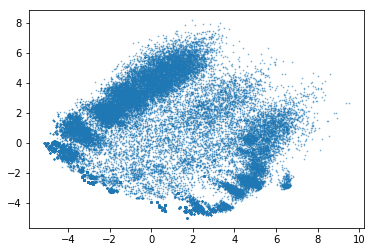

In [163]:

pca = decomposition.PCA(n_components=2)

reduced_sample_matrix = pca.fit_transform(sample_matrix)

dim1, dim2 = reduced_sample_matrix[:, 0], reduced_sample_matrix[:, 1]
plt.scatter(dim1, dim2, s=0.5, alpha=0.5)
plt.show()

### Create a distance between hidden states

In [92]:
def vectorize_state_with_softmax(state, with_output=False):
    """take a state of the form (output, (hidden, cell)) as input.
        Softmax cell state and hidden states to use JS divergence on it
        WARNING : Compatible only with distance on proba distrib (e.g JS_div)"""
    hidden, cell = state[1]
    hidden, cell = F.softmax(hidden.view(-1)).data.numpy(), F.softmax(cell.view(-1)).data.numpy()
    return np.concatenate((hidden, cell))

In [77]:
def vectorize_state_without_softmax(state):
    """take a state of the form (output, (hidden, cell)) as input.
    returns tensor"""
    hidden, cell = state[1]
    hidden, cell = hidden.data.view(-1), cell.data.view(-1)
    return torch.cat((hidden, cell))

In [78]:
def make_sklearn_compatible_matrix(vectorized_state_list):
    return np.matrix(vectorized_state_list)

In [79]:
# First try : softmax hidden_state, then JS_divergence on all

In [80]:
def distance_JS_on_all_without_softmax(state1, state2):
    """ state must be vectorized and softmaxed : use vectorize_state_with_softmax"""
    output1 = state1[0].data.numpy()
    hidden_state1, cell_state1 = state1[1]
    hidden_state1, cell_state1 = F.softmax(hidden_state1).data.numpy(), F.softmax(cell_state1).data.numpy()
    output2 = state2[0].data.numpy()
    hidden_state2, cell_state2 = state2[1]
    hidden_state2, cell_state2 = F.softmax(hidden_state2).data.numpy(), F.softmax(cell_state2).data.numpy()
    # Should we take the mean ? the max ??
    return np.mean([JS_divergence(hidden_state1, hidden_state2), JS_divergence(cell_state1, cell_state2)])

In [81]:
def euclidian_distance_on_state(state1, state2):
    """state must be of the form (output, (hidden, cell))"""
    hidden1, cell1 = state1[1]
    hidden2, cell2 = state2[1]
    # mean ? max ? 
    return np.mean([(hidden1 - hidden2).norm(2).data.numpy(), (cell1 - cell2).norm(2).data.numpy()])

In [83]:
def euclidian_distance(state1, state2):
    """on vectorized states (pytorch tensor)"""
    return (state1 - state2).norm(2)

In [168]:
# Second try : JS_div on output, euclidian distance on hidden states

In [1]:
def distance_JS_euclidian_mix(state1, state2):
    """ TODO"""

### Test the distance

In [121]:
def test_distance(state_list, vectorized_state_list,  distance=euclidian_distance, verification_distance=JS_divergence, n_examples=10):
    distance_list = list()
    verification_distance_list = list()
    for i in range(n_examples):
        index1 = np.random.choice([i for i in range(len(state_list))], replace=False)  #be careful if n_example > len(state_list)
        index2 = np.random.choice([i for i in range(len(state_list))], replace=False)
        state1, state2 = vectorized_state_list[index1], vectorized_state_list[index2]
        hidden1, hidden2 = state_list[index1][1], state_list[index2][1]
        distance_list.append(distance(state1, state2))
        l = list()
        for char in char_vect[:30]:
            input_tensor = Variable(text2input(char)[-1])
            output1, new_hidden1 = rnn_vanilla(input_tensor,hidden1)
            output2, new_hidden2 = rnn_vanilla(input_tensor, hidden2)
            output1, output2 = F.softmax(output1), F.softmax(output2)
            l.append(verification_distance(output1.data.numpy(), output2.data.numpy()))
        verification_distance_list.append(np.mean(l))
    plt.scatter(distance_list, verification_distance_list)
    plt.show()
    return distance_list, verification_distance_list

In [93]:
vectorized_state_list = [vectorize_state_without_softmax(state) for state in state_list]
softmaxed_state_list = [vectorize_state_with_softmax(state) for state in state_list]

In [98]:
import sklearn.linear_model

In [129]:
model = sklearn.linear_model.LinearRegression(fit_intercept=False)

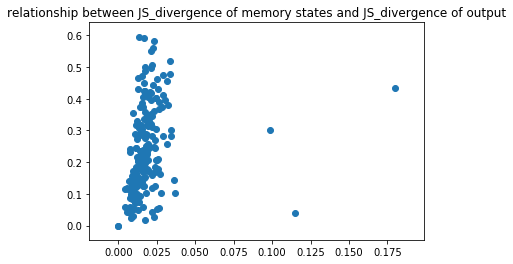

CPU times: user 9min 55s, sys: 2.08 s, total: 9min 57s
Wall time: 47.7 s


In [132]:
%%time
plt.title("relationship between JS_divergence of memory states and JS_divergence of output")
distance_list, verification_distance_list = test_distance(state_list, softmaxed_state_list, distance = JS_divergence, n_examples=200, verification_distance=JS_divergence)

In [133]:
model.fit(np.array(distance_list).reshape(-1, 1), np.array(verification_distance_list).reshape(-1, 1))
model.score(np.array(distance_list).reshape(-1, 1), np.array(verification_distance_list).reshape(-1, 1))

-0.84201680819545377

In [134]:
model.coef_

array([[ 8.10675093]])

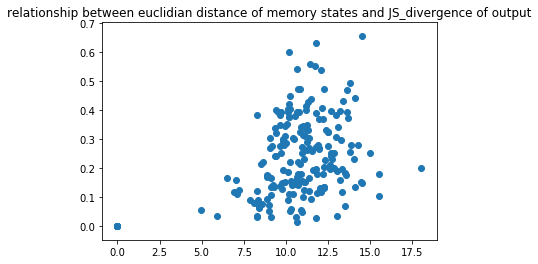

CPU times: user 9min 6s, sys: 1.88 s, total: 9min 8s
Wall time: 46.3 s


In [137]:
%%time
plt.title("relationship between euclidian distance of memory states and JS_divergence of output")
distance_list2, verification_distance_list2 = test_distance(state_list, vectorized_state_list, distance = euclidian_distance, n_examples=200, verification_distance=JS_divergence)

In [138]:
model.fit(np.array(distance_list2).reshape(-1, 1), np.array(verification_distance_list2).reshape(-1, 1))
model.score(np.array(distance_list2).reshape(-1, 1), np.array(verification_distance_list2).reshape(-1, 1))

0.14231934385695455

In [139]:
model.coef_

array([[ 0.02198926]])

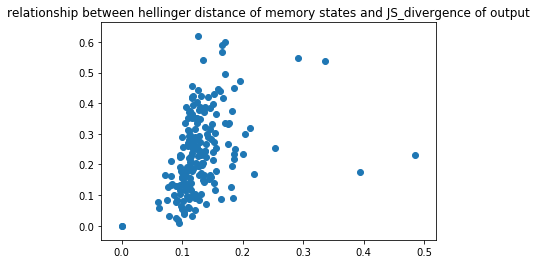

CPU times: user 8min 51s, sys: 1.7 s, total: 8min 52s
Wall time: 49.1 s


In [149]:
%%time
plt.title("relationship between hellinger distance of memory states and JS_divergence of output")
distance_list3, verification_distance_list3 = test_distance(state_list, softmaxed_state_list, distance = hellinger, n_examples=200, verification_distance=JS_divergence)

In [152]:
model.fit(np.array(distance_list3).reshape(-1, 1), np.array(verification_distance_list3).reshape(-1, 1))
model.score(np.array(distance_list3).reshape(-1, 1), np.array(verification_distance_list3).reshape(-1, 1))

0.051176350285024208

In [153]:
model.coef_

array([[ 1.69741306]])

In [140]:
from scipy.stats import linregress

In [142]:
linregress(distance_list, verification_distance_list)

LinregressResult(slope=2.017881188030346, intercept=0.19819399607973714, rvalue=0.23703283324067098, pvalue=0.00072636453999109498, stderr=0.58775729315577807)

In [143]:
linregress(distance_list2, verification_distance_list2)

LinregressResult(slope=0.019856754482736872, intercept=0.024134211146764145, rvalue=0.37958339179671496, pvalue=2.9675048497525979e-08, stderr=0.0034394116267528227)

## Test the clustering

In [144]:
import sklearn.cluster

In [90]:
import scipy.cluster

In [157]:
vectorized_state_list, softmaxed_state_list = 0, 0

In [166]:
kmeans = sklearn.cluster.KMeans(n_jobs=-1).fit(sample_matrix[:1000])

In [ ]:
kmeans.labels_

In [170]:
def test_clustering(state_list, cluster_labels, nb_clusters=8, distance=JS_divergence):
    state_list = np.array(state_list)
    cluster_list = [state_list[np.nonzero(cluster_labels==i)] for i in range(nb_clusters)]
    mean_intra_cluster_div_list = list()
    for i in range(nb_clusters):
        l = list()
        for n in range(10):
            index1 = np.random.choice(cluster_list[i], 1, replace=False)
            index2 = np.random.choice(cluter_list[i], 1, replace=False)
            hidden1, hidden2 = state_list[index1][1], state_list[index2][1]
            for char in np.random.choice(char_vect, 20):
                input_tensor = Variable(text2input(char)[-1])
                output1, _ = rnn_vanilla(input_tensor, hidden1)
                output2, _ = rnn_vanilla(input_tensor, hidden2)
                output1, output2 = F.softmax(output1), F.softmax(output2)
                l.append(distance(output1, output2))
        mean_intra_cluster_div_list.append(np.mean(l))
    return mean_intra_cluster_div_list

In [91]:
from scipy.cluster.hierarchy import fclusterdata

%%time
l = fclusterdata(sample_matrix[:500], 1.15,  metric=JS_divergence, method="average")
print(l)
print(len(np.unique(l)))

In [78]:
sample_matrix = make_sklearn_compatible_matrix(vectorized_state_list)

In [86]:
clusterizer = sklearn.cluster.AgglomerativeClustering(n_clusters=10, affinity=JS_divergence, linkage="complete")

In [87]:
sklearn.cluster.AgglomerativeClustering()

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func=<function mean at 0x7f618b53eb90>)

In [ ]:
%%time
clusterizer.fit_predict(sample_matrix)